In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import scipy.stats as stats

Виконав розвідковий аналіз (EDA)

In [2]:
df = pd.read_csv('Student_Performance.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [3]:
df.describe()


,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [4]:
df.isnull().sum()


Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

Побудував теплову карту кореляцій

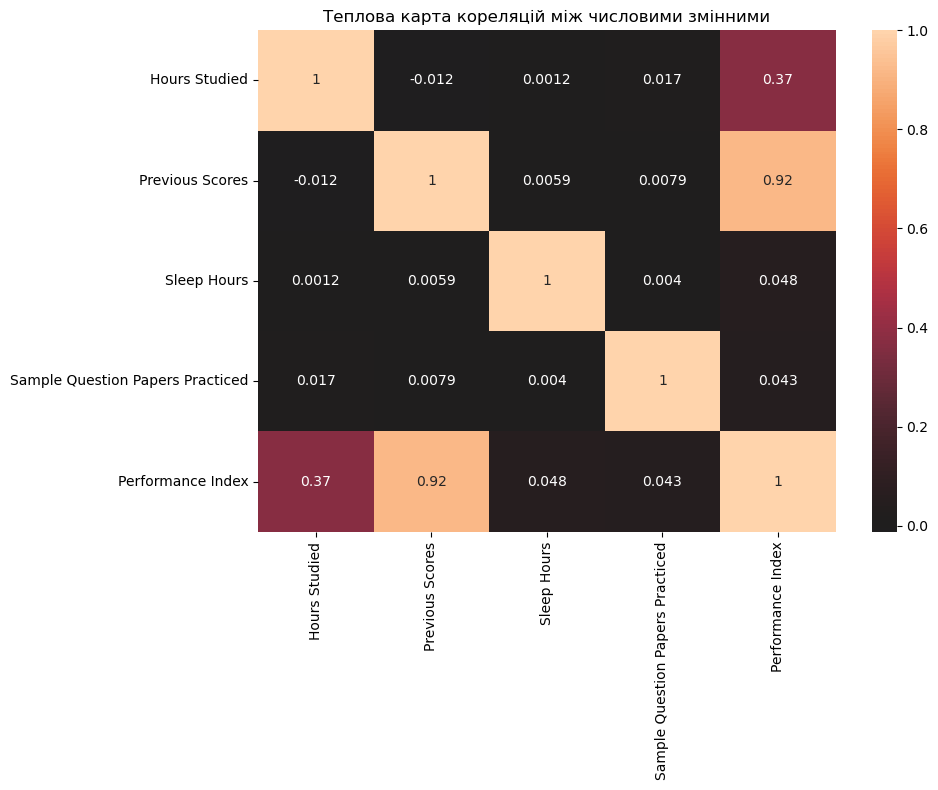

In [5]:
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True,  center=0)
plt.title('Теплова карта кореляцій між числовими змінними')
plt.tight_layout()
plt.show()

Виконав обробку категоріальних змінних

In [6]:
print("Extracurricular Activities:", df['Extracurricular Activities'].unique())

Extracurricular Activities: ['Yes' 'No']


In [7]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'No': 0, 'Yes': 1})

Виконав вибір ознак та цільової змінної

In [8]:
X = df.drop('Performance Index', axis=1)
y = df['Performance Index']

In [9]:
print("Features:", X.columns.tolist())
print("Target: Performance Index")

Features: ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
Target: Performance Index


Поділив на навчальну та тестову вибірки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
print(f"\n=== Розміри вибірок ===")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


=== Розміри вибірок ===
X_train: (8000, 5)
X_test: (2000, 5)
y_train: (8000,)
y_test: (2000,)


Нормалізував/Стандартизував дані (Середнє значення = 0 / Стандартне відхилення = 1)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Додав стовпчик одиниць для intercept(вільний член) - вектор одиниць

In [13]:
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

In [14]:
print(f"\n=== Фінальні розміри даних ===")
print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")


=== Фінальні розміри даних ===
X_train_final: (8000, 6)
X_test_final: (2000, 6)


Реалізував функцію для обчислення функції втрат (MSE). Градієнтний спуск використовує MSE, щоб знайти такі коефіцієнти b, при яких MSE → min, тобто наші прогнози максимально близькі до реальних значень!

In [15]:
def compute_cost(X, y, b):
    predictions = X.dot(b)
    errors = predictions - y
    mse = (1 / len(y)) * np.sum(errors ** 2)
    return mse

Реалізував функцію градієнтного спуску

In [16]:
def gradient_descent(X, y, b, learning_rate, epochs):
    cost_history = []  # Для відстеження змін MSE
    m = len(y) # Кількість спостережень
    
    for epoch in range(epochs):
        # Обчислення передбачень
        predictions = X.dot(b)
        
        # Обчислення помилки
        errors = predictions - y
        
        # Обчислення градієнта (похідна MSE за b)
        gradient = (2/m) * X.T.dot(errors)
        
        # Оновлення ваг
        b = b - learning_rate * gradient
        
        # Збереження поточного MSE для історії
        current_cost = compute_cost(X, y, b)
        cost_history.append(current_cost)
        
        # Вивід прогресу кожні 100 ітерацій
        if epoch % 100 == 0:
            print(f"Епоха {epoch}: MSE = {current_cost:.4f}")
    
    return b, cost_history

Визначив кількість ітерацій (epochs) та швидкість навчання (learning_rate)

In [17]:
b = np.zeros(X_train_final.shape[1])
learning_rate = 0.01
epochs = 1000

Почав навчання градієнтним спуском

In [18]:
b_final, cost_history = gradient_descent(X_train_final, y_train, b, learning_rate, epochs)


Епоха 0: MSE = 3292.5390
Епоха 100: MSE = 62.1804
Епоха 200: MSE = 5.1938
Епоха 300: MSE = 4.1878
Епоха 400: MSE = 4.1701
Епоха 500: MSE = 4.1697
Епоха 600: MSE = 4.1697
Епоха 700: MSE = 4.1697
Епоха 800: MSE = 4.1697
Епоха 900: MSE = 4.1697


In [19]:
feature_names = ['Intercept'] + X.columns.tolist()
for i, (name, coef) in enumerate(zip(feature_names, b_final)):
    print(f"{name}: {coef:.4f}")

Intercept: 55.3115
Hours Studied: 7.4013
Previous Scores: 17.6373
Extracurricular Activities: 0.3043
Sleep Hours: 0.8100
Sample Question Papers Practiced: 0.5488


Мінімальний очікуваний Performance Index

Кожна додаткова година навчання дає +7.40 балів

Кожен додатковий бал у попередніх оцінках дає +17.64 балів

Кожна додаткова година сну дає +0.81 бал

Кожен додатковий практичний тест дає +0.55 балів

Участь у позакласних заходах дає лише +0.30 балів

Побудував графік збіжності функції втрат

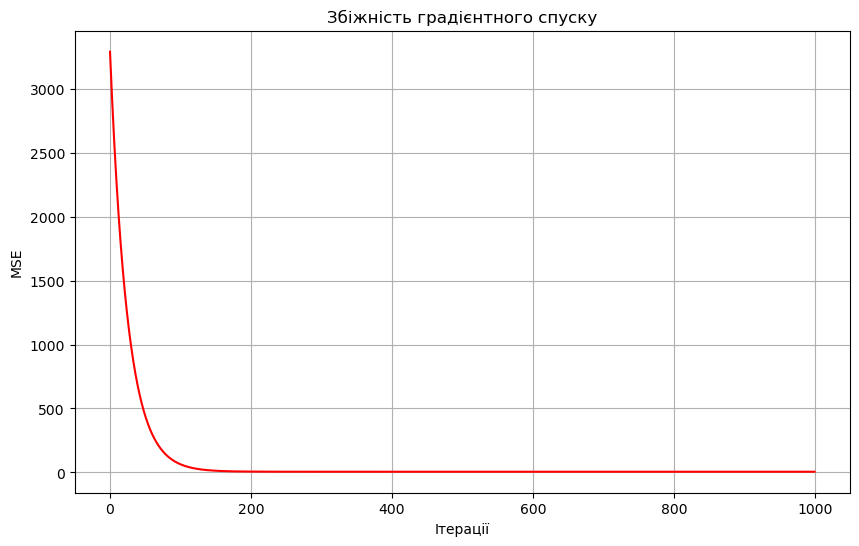

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(cost_history, color='red')
plt.title('Збіжність градієнтного спуску')
plt.xlabel('Ітерації')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

Згідно графіка видно стабільну збіжність

Обрахував значення метрик MSE та R² на тестовій вибірці та вивів їх.

In [21]:
y_pred = X_test_final.dot(b_final)

mse_test = np.mean((y_test - y_pred) ** 2)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

y_baseline = np.full_like(y_test, np.mean(y_train))
mse_baseline = np.mean((y_test - y_baseline) ** 2)
r2_baseline = 1 - (np.sum((y_test - y_baseline) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))


In [22]:
print(f"Тестова MSE: {mse_test:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Бейзлайн MSE: {mse_baseline:.4f}")
print(f"Бейзлайн R²: {r2_baseline:.4f}")

Тестова MSE: 4.0826
R² Score: 0.9890
Бейзлайн MSE: 370.7730
Бейзлайн R²: -0.0005


надзвичайно висока точність прогнозування (R² = 0.989) та мінімальна помилка (MSE = 4.08)

Побудував графік прогнозованих/фактичних значень

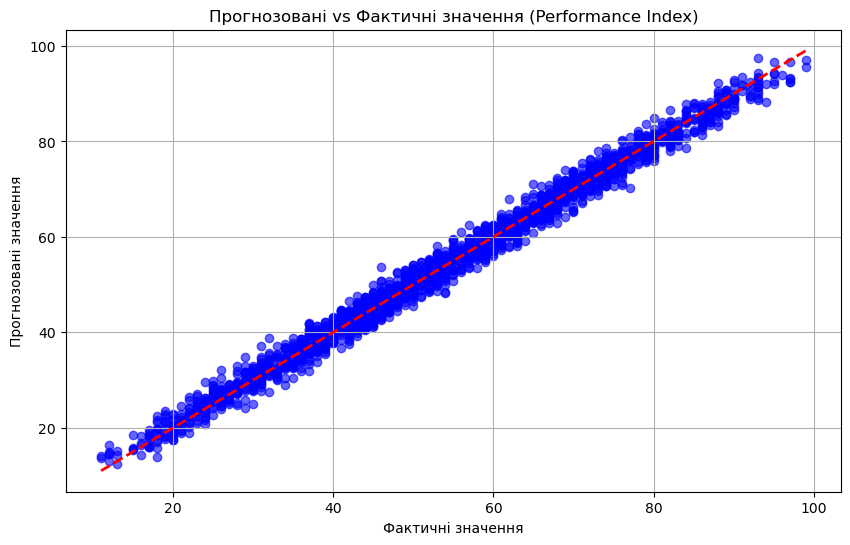

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактичні значення')
plt.ylabel('Прогнозовані значення')
plt.title('Прогнозовані vs Фактичні значення (Performance Index)')
plt.grid(True)
plt.show()

In [24]:
residuals = y_test - y_pred


Побудував графік залишків vs. прогнозів для визначення лінійності зв'язку між змінними

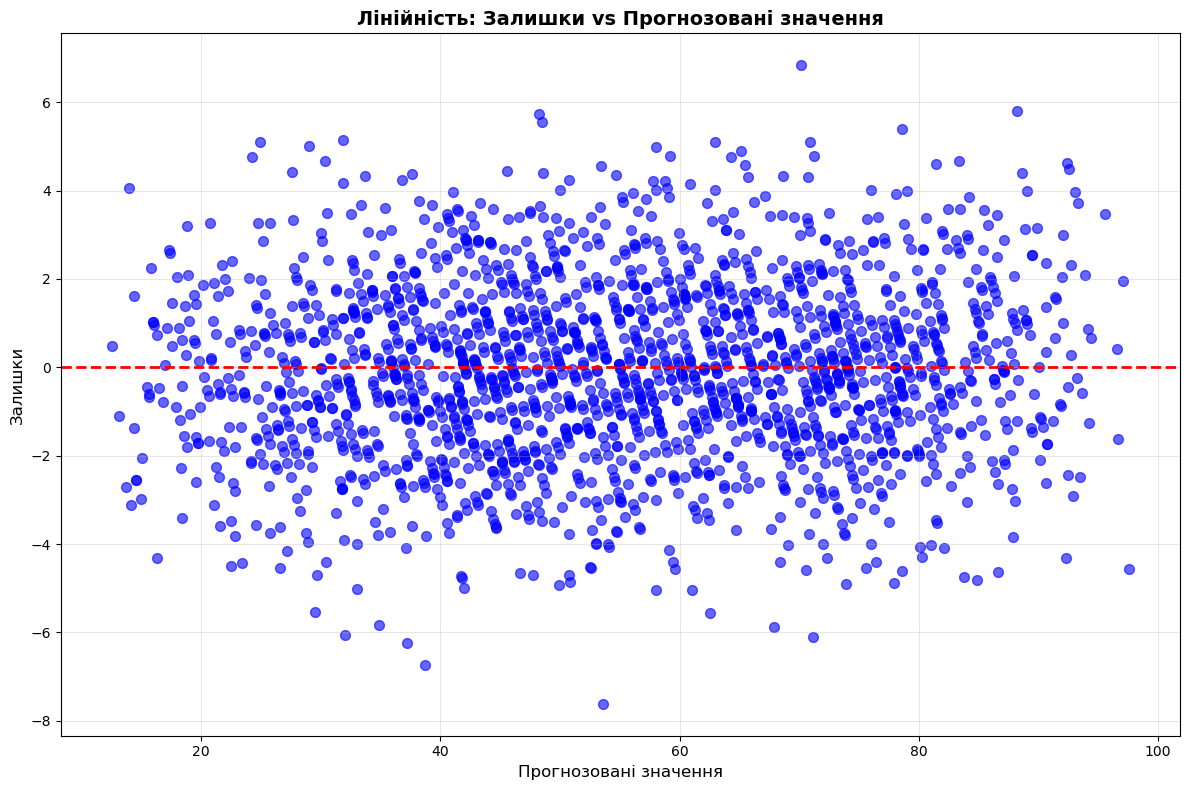

In [35]:
plt.figure(figsize=(12, 8))
plt.scatter(y_pred, residuals, alpha=0.6, s=50, color='blue')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Прогнозовані значення', fontsize=12)
plt.ylabel('Залишки', fontsize=12)
plt.title('Лінійність: Залишки vs Прогнозовані значення', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Залишки випадково розкидаються навколо нуля. НЕ U-подібна форма 

Визначив VIF для перевірки відсутності мультиколінеарності

In [ ]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
X_train_features = pd.DataFrame(X_train_final[:,1:], columns=X.columns)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_features.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_features.values, i) for i in range(X_train_features.shape[1])]
print("\n=== VIF (Variance Inflation Factor) ===")
print(vif_data)


=== VIF (Variance Inflation Factor) ===
                            Feature       VIF
0                     Hours Studied  1.000387
1                   Previous Scores  1.000243
2        Extracurricular Activities  1.000428
3                       Sleep Hours  1.000461
4  Sample Question Papers Practiced  1.000320


VIF < 5  (або консервативніше  < 10 ) - відсутність серйозної мультиколінеарності.
усі VIF ≈ 1.0 (далеко нижче навіть від порогу 5)

Висновок: мультиколінеарності немає, ознаки незалежні

Побудував графік нормальності залишків (Q-Q Plot)

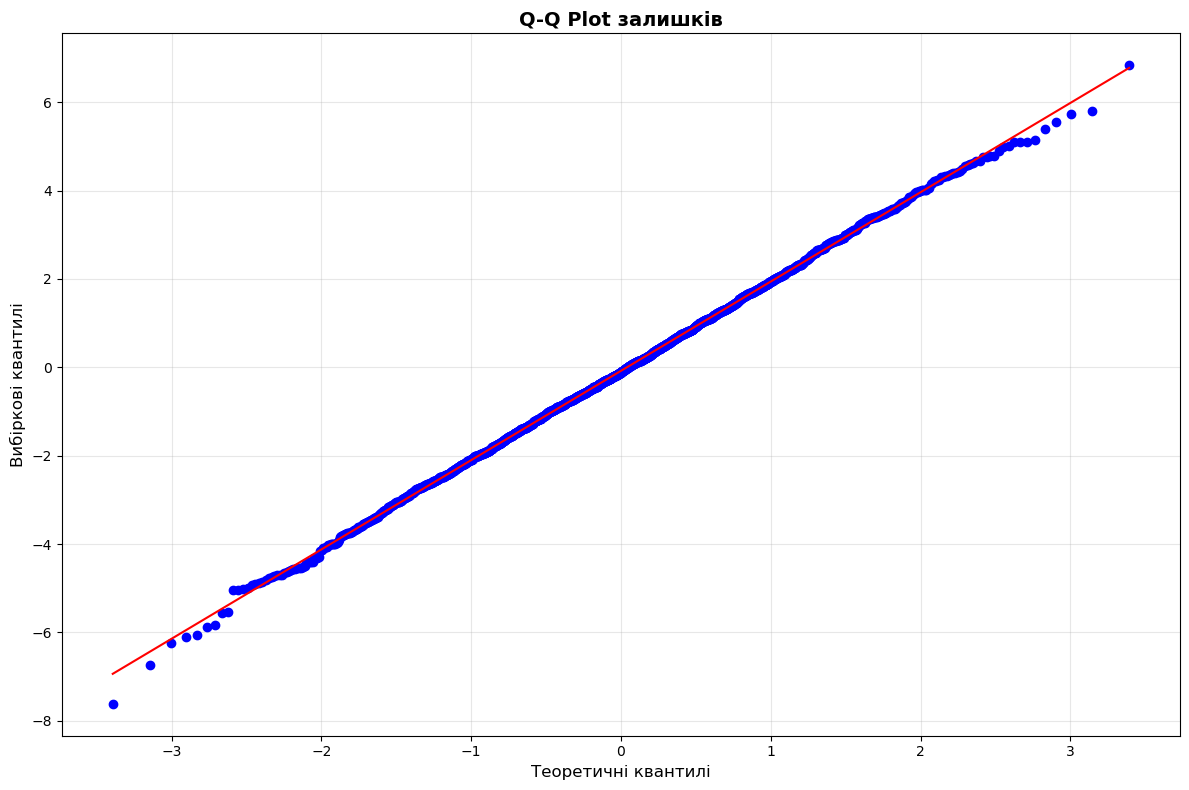

In [32]:
plt.figure(figsize=(12, 8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot залишків', fontsize=14, fontweight='bold')
plt.xlabel('Теоретичні квантилі', fontsize=12)
plt.ylabel('Вибіркові квантилі', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

залишки дуже добре підкоряються нормальному розподілу.

Провів тест Shapiro-Wilk на нормальність

In [ ]:
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n=== Тест нормальності Shapiro-Wilk ===")
print(f"Статистика: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")


=== Тест нормальності Shapiro-Wilk ===
Статистика: 0.9996, p-value: 0.9751


 p-value > 0.05  говорить про нормальність

Побудував графік постійності дисперсії залишків для визначення гомоскедастичністі

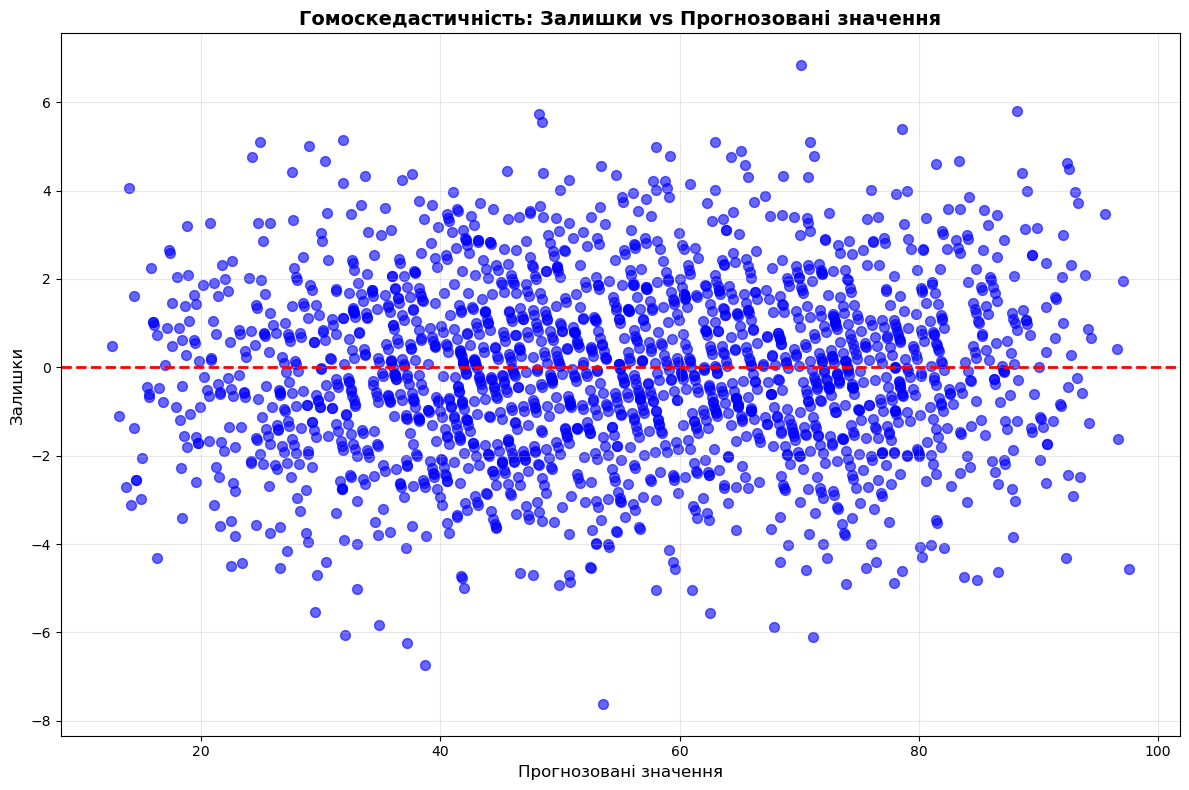

In [34]:
plt.figure(figsize=(12, 8))
plt.scatter(y_pred, residuals, alpha=0.6, s=50, color='blue')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Прогнозовані значення', fontsize=12)
plt.ylabel('Залишки', fontsize=12)
plt.title('Гомоскедастичність: Залишки vs Прогнозовані значення', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

"Хмара" точок має приблизно однакову ширину по всій довжині. Хмара не нагадує "воронку"

Побудував графік автокореляції залишків у моделі лінійної регресії

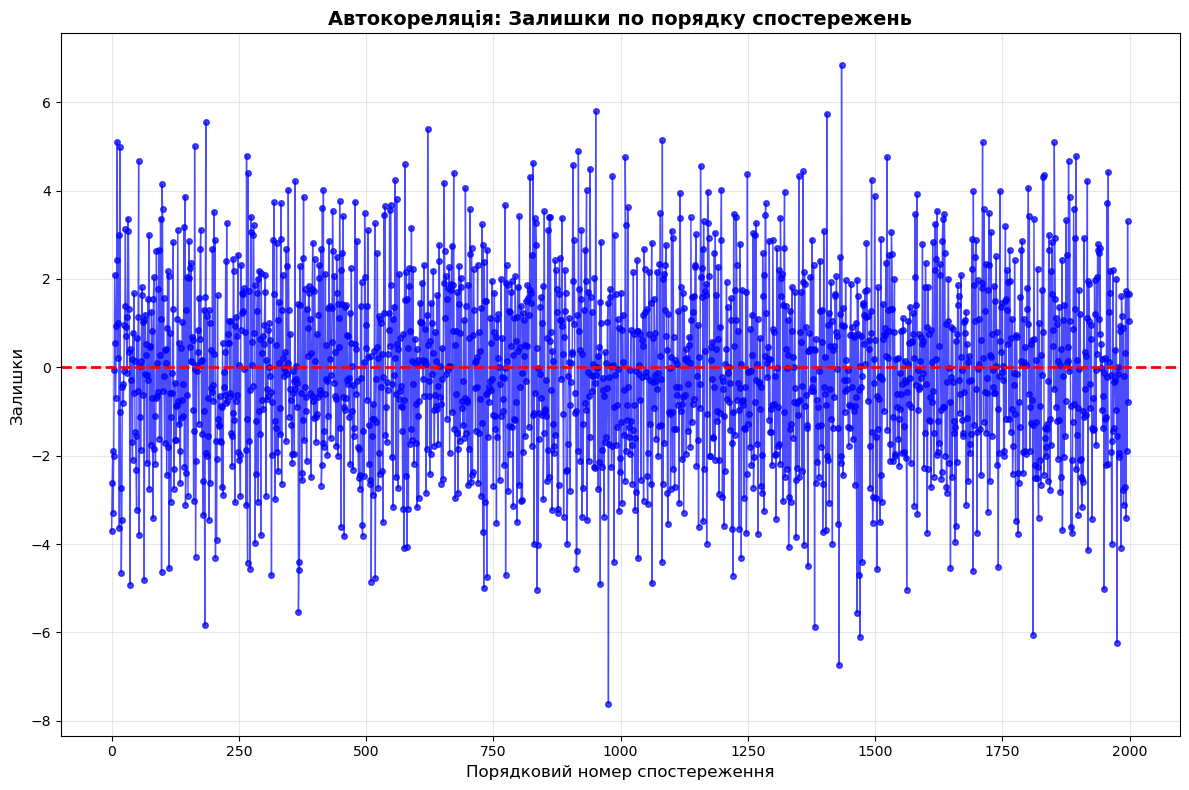

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(residuals.values, marker='o', alpha=0.7, linewidth=1, markersize=4, color='blue')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Порядковий номер спостереження', fontsize=12)
plt.ylabel('Залишки', fontsize=12)
plt.title('Автокореляція: Залишки по порядку спостережень', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Залишки хаотично розподілені навколо нуля, отже сильних ознак автокореляції немає,

Обчислив статистику Дарбіна-Вотсона, щоб перевірити відсутність автокореляції залишків у моделі лінійної регресії.

In [38]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Статистика Дарбіна-Вотсона: {dw_stat:.4f}")

Статистика Дарбіна-Вотсона: 2.0472


Значення близьке до 2.0 означає відсутність автокореляції.

Побудував графік впливових спостережень, щоб ідентифікувати впливові спостереження в моделі лінійної регресії на основі значень Cook's Distance.

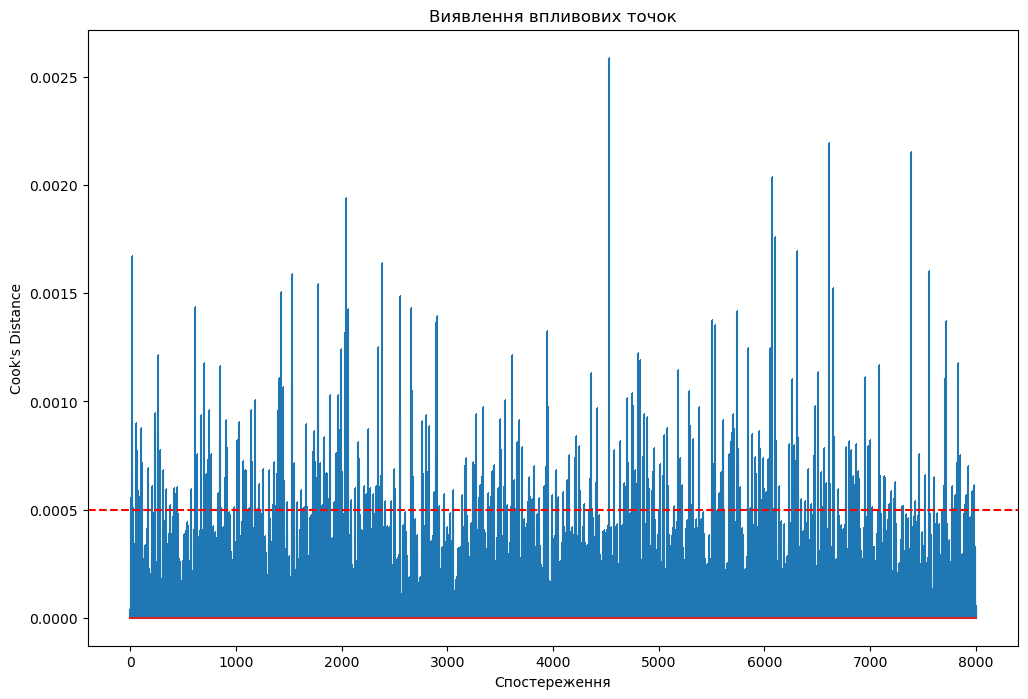

Індекси впливових спостережень: [  10   18   19   22   51   62   63   70   89  101  108  168  206  235
  237  260  265  282  305  340  377  416  419  443  571  612  632  635
  666  693  720  730  733  742  757  762  834  835  844  851  859  898
  906  918  978 1010 1016 1033 1066 1083 1097 1120 1144 1149 1182 1201
 1205 1218 1259 1312 1315 1346 1360 1365 1384 1394 1406 1414 1422 1443
 1449 1458 1478 1528 1534 1549 1553 1574 1616 1632 1645 1661 1671 1725
 1728 1736 1741 1746 1749 1771 1775 1778 1799 1818 1835 1842 1849 1854
 1861 1873 1889 1891 1931 1945 1967 1985 1991 2004 2030 2038 2052 2053
 2056 2088 2090 2127 2152 2166 2210 2227 2250 2265 2298 2299 2327 2343
 2355 2365 2369 2377 2407 2467 2493 2500 2547 2550 2657 2658 2665 2671
 2758 2771 2797 2819 2827 2872 2890 2897 2898 2921 2970 3049 3055 3136
 3168 3172 3245 3247 3260 3271 3272 3296 3313 3329 3336 3380 3399 3409
 3421 3433 3442 3476 3500 3505 3531 3541 3544 3564 3598 3602 3604 3609
 3633 3643 3662 3674 3703 3759 3772 3776 3785

In [ ]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train_final[:,1:]) 
model = sm.OLS(y_train, X_train_sm).fit()

influence = model.get_influence()
(c, p) = influence.cooks_distance

plt.figure(figsize=(12, 8))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.axhline(y=4/len(c), color='red', linestyle='--')
plt.xlabel("Спостереження")
plt.ylabel("Cook's Distance")
plt.title("Виявлення впливових точок")
plt.show()

# Впливові спостереження
influential_points = np.where(c > 4/len(c))[0]
print("Індекси впливових спостережень:", influential_points)

на результати регресії сильно впливають окремі точки